# 基于缠论的浪型识别

In [ ]:
import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

import scipy.optimize as optimize
import matplotlib.pyplot as plt

from Chan import Chan

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] * 1000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.tracking_id = None
        self.direction = None
        self.signal = None
        self.signal_executed = False
        self.chan = Chan()
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.5
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, window=8, amp_pct=0.005):
        # if len(bars) < window: return
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()
        return bars
    
    def get_open_signal(self, bars, bi_status, log=False):
        def format_time(date):
            date = str(date)
            return date[11:16]
        if self.chan.df_merged.empty: return None
        df_merged = self.chan.df_merged
        df_pivot = df_merged[df_merged["pivot"].notna()]
        bi = df_merged[df_merged["bi"] & df_merged["pivot"].notna()]
        if len(bi) < 3: return None
                    
        ubi = bi.iloc[-3:]
        pivot_candidate = df_pivot.iloc[self.chan.candidate]
        # print(ubi.iloc[0]["date"], ubi.iloc[1]["date"], pivot_candidate["date"])
        
        # ----------------------------------------
        # 这一段要修改 last_id是最新的candidate点
        # last_id = bi.index[-1]
        # if self.tracking_id and (last_id - self.tracking_id >= 2):
        #     self.tracking_id = None
            
        df = bars[bars["date"] > pivot_candidate["date"]]
        if len(df) < 1: return None
        if ubi.iloc[0]["pivot"] == "up":
            A = ubi.iloc[0]["high"]
            B = ubi.iloc[1]["low"]
            C = ubi.iloc[2]["high"]
            D = pivot_candidate["low"]
            # 下降趋势 且 确认走势不被破环
            if A > C > B > D and df['high'].max() < C:
                # self.tracking_id = pivot_candidate.name
                # print(bars.iloc[-1]['date'], self.tracking_id)
                self.direction = -1
                open_price = ubi.iloc[2]["low"]
                stop_loss_price = C
                profit_price = D
                if abs((profit_price - open_price) / (stop_loss_price - open_price)) >= 2:
                    if log:
                        print(f'空头趋势:{format_time(bars.iloc[-1]["date"])}---{format_time(ubi.iloc[0]["date"])}/{format_time(ubi.iloc[1]["date"])}/{format_time(ubi.iloc[2]["date"])}/{format_time(pivot_candidate["date"])}')
                        print(f'candidate 之后的df {format_time(df.iloc[0]["date"])}-{format_time(df.iloc[-1]["date"])}')
                        print(f'{A}-{B}-{C}-{D}')
                    return self.direction, open_price, profit_price, stop_loss_price, "下降趋势做空"
        if ubi.iloc[0]["pivot"] == "down":
            A = ubi.iloc[0]["low"]
            B = ubi.iloc[1]["high"]
            C = ubi.iloc[2]["low"]
            D = pivot_candidate["high"]
            # 上升趋势 且 确认走势不被破环
            if A < C < B < D and df['low'].min() > C:
                # 此时是candidate符合了，上升趋势，存在开单的可能
                # self.tracking_id = pivot_candidate.name
                # print(bars.iloc[-1]['date'], self.tracking_id)
                self.direction = 1
                open_price = ubi.iloc[2]["high"]
                stop_loss_price = C
                profit_price = D
                if abs((profit_price - open_price) / (stop_loss_price - open_price)) >= 2:
                    if log:
                        print(f'多头趋势:{format_time(ubi.iloc[0]["date"])}/{format_time(ubi.iloc[1]["date"])}/{format_time(ubi.iloc[2]["date"])}/{format_time(pivot_candidate["date"])}')
                        print(f'candidate 之后的df {format_time(df.iloc[0]["date"])}-{format_time(df.iloc[-1]["date"])}')
                        print(f'{A}-{B}-{C}-{D}')
                    return self.direction, open_price, profit_price, stop_loss_price, "上升趋势做多"
        return None
    
    def update(self, bars):
        bi_status = self.chan.update(bars.iloc[-1], log=False)
        
        # 开仓信号
        position = self.find_position()
        if not position:
            signal = self.get_open_signal(bars, bi_status)
            if signal and self.signal != signal:
                self.signal = signal
                self.signal_executed = False
        if self.signal is None: return
        direction, open_price, profit_price, stop_loss_price, reason = self.signal
        
        position = self.find_position()
        amount = self.calculate_open_amount(bars)
        if self.signal and not position and not self.signal_executed and not is_within_specific_minutes_of_close(bars, 31):
            if self.pm.open_position_LMT(self.contract, "Trend", direction * amount, open_price, bars, reason=reason):
                self.signal_executed = True
            return
        
        position = self.find_position()
        if self.signal and position:
            # self.pm.close_position_LMT(position, stop_loss_price, bars)
            if bars.iloc[-1]["low"] <= profit_price <= bars.iloc[-1]["high"]:
                self.pm.close_position(position, bars, reason="止盈")
                return
            if bars.iloc[-1]["low"] <= stop_loss_price <= bars.iloc[-1]["high"]:
                self.pm.close_position(position, bars, reason="止损")
                return
            if (bars.iloc[-1]["date"] - position["date"]) >= pd.Timedelta(minutes=30):
                self.pm.close_position(position, bars, reason="时间到期")
                return
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        self.afterMarketCloseEvent += [self.after_market_close]
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)
        
    def after_market_close(self, date):
        for key, trend in self.trend.items():
            trend.chan = Chan()
            trend.signal = None
            trend.signal_executed = False

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=True)
    end_date = "2025-03-31"
    duration_str = "200 D"
    ba.minutes_backtest(end_date, duration_str)
finally:
    if ba.ib: pass
        # ba.ib.disconnect()

【2024-06-12 15:24:00-04:00】【Trend】开仓: AAPL, 价格: 218.81, 数量：2290，浮动盈亏：None, 原因：上升趋势做多
【2024-06-12 15:25:00-04:00】【Trend】平仓: AAPL, 价格: 218.43, 数量：-2290，浮动盈亏：-870.1999999999896, 原因：止损
【2024-06-13 11:49:00-04:00】【Trend】开仓: AAPL, 价格: 214.07, 数量：-2340，浮动盈亏：None, 原因：下降趋势做空
【2024-06-13 12:16:00-04:00】【Trend】平仓: AAPL, 价格: 212.21, 数量：2340，浮动盈亏：4352.399999999965, 原因：止盈
【2024-06-13 13:39:00-04:00】【Trend】开仓: AAPL, 价格: 212.9, 数量：2340，浮动盈亏：None, 原因：上升趋势做多
【2024-06-13 13:46:00-04:00】【Trend】平仓: AAPL, 价格: 212.65, 数量：-2340，浮动盈亏：-585.0, 原因：止损
【2024-06-14 12:24:00-04:00】【Trend】开仓: AAPL, 价格: 212.29, 数量：-2360，浮动盈亏：None, 原因：下降趋势做空
【2024-06-14 12:30:00-04:00】【Trend】平仓: AAPL, 价格: 211.86, 数量：2360，浮动盈亏：1014.799999999949, 原因：止盈
【2024-06-14 13:38:00-04:00】【Trend】开仓: AAPL, 价格: 212.29, 数量：-2360，浮动盈亏：None, 原因：下降趋势做空
【2024-06-14 14:08:00-04:00】【Trend】平仓: AAPL, 价格: 211.91, 数量：2360，浮动盈亏：896.7999999999893, 原因：时间到期
【2024-06-14 14:54:00-04:00】【Trend】开仓: AAPL, 价格: 212.32, 数量：-2360，浮动盈亏：None, 原因：下降趋势做空
【2024-06-14 15:24:00-04

Peer closed connection.


In [5]:
pd.DataFrame(ba.pm.trade_log)

,date,symbol,strategy,open_or_close,direction,price,amount,commission,pnl,reason
0,2025-03-04 11:08:00-05:00,AAPL,Trend,开仓,BUY,237.96,2100,39.977280,NaN,上升趋势做多
1,2025-03-04 11:38:00-05:00,AAPL,Trend,平仓,SELL,238.90,-2100,40.135200,1974.0,时间到期
2,2025-03-04 12:07:00-05:00,AAPL,Trend,开仓,BUY,238.52,2100,40.071360,NaN,上升趋势做多
3,2025-03-04 12:29:00-05:00,AAPL,Trend,平仓,SELL,238.17,-2100,40.012560,-735.0,止损
4,2025-03-04 13:13:00-05:00,AAPL,Trend,开仓,SELL,237.70,-2110,40.123760,NaN,下降趋势做空
...,...,...,...,...,...,...,...,...,...,...
115,2025-03-31 13:22:00-04:00,AAPL,Trend,平仓,SELL,219.55,-2270,39.870280,-499.4,止损
116,2025-03-31 14:09:00-04:00,AAPL,Trend,开仓,SELL,220.63,-2260,39.889904,NaN,下降趋势做空
117,2025-03-31 14:10:00-04:00,AAPL,Trend,平仓,BUY,220.81,2260,39.922448,-406.8,止损
118,2025-03-31 15:26:00-04:00,AAPL,Trend,开仓,BUY,221.27,2260,40.005616,NaN,上升趋势做多


93 2024-10-24


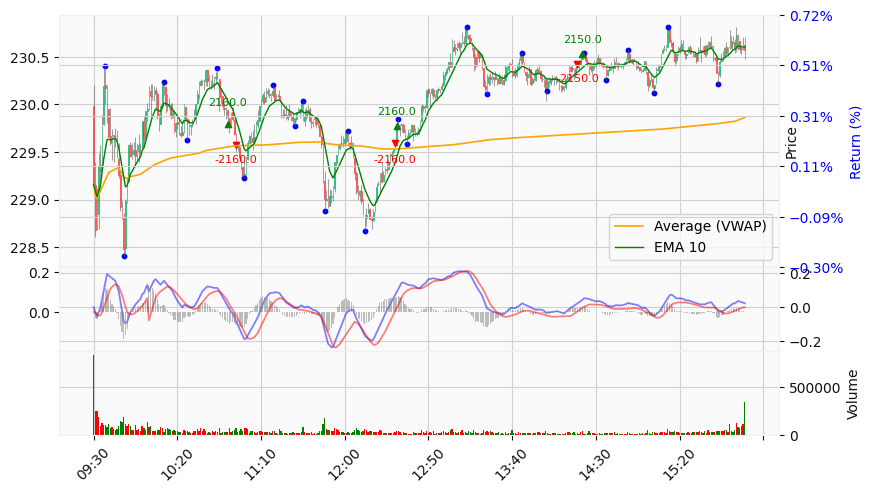

In [177]:
from PlotPlus import PlotPlus
# idx = 0
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')
chan = Chan()
while True:
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    df, df_merged = chan.process(df, log=False)

    pp = PlotPlus(df.iloc[:])
    pp.plot_basic(style_type="candle")
    # mark pivot
    # pp.mark_point(df.iloc[:][(df['pivot'] == 'up')], "high", color="red")
    # pp.mark_point(df.iloc[:][(df['pivot'] == 'down')], "low", color="green")
    pp.mark_point(df.iloc[:][df["bi"] & (df['pivot'] == 'up')], "high")
    pp.mark_point(df.iloc[:][df["bi"] & (df['pivot'] == 'down')], "low")
    
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    break

In [26]:
ba.statistic()

{'cumulative_pnl': np.float64(-35890.78174400062),
 'max_drawdown': np.float64(0.04147293992588252),
 'sharpe_ratio': np.float64(-3.426765066338979),
 'volatility': np.float64(0.02330416482968315),
 'daily_return': np.float64(-0.00017800753150223683),
 'commission': np.float64(38937.164256000004)}

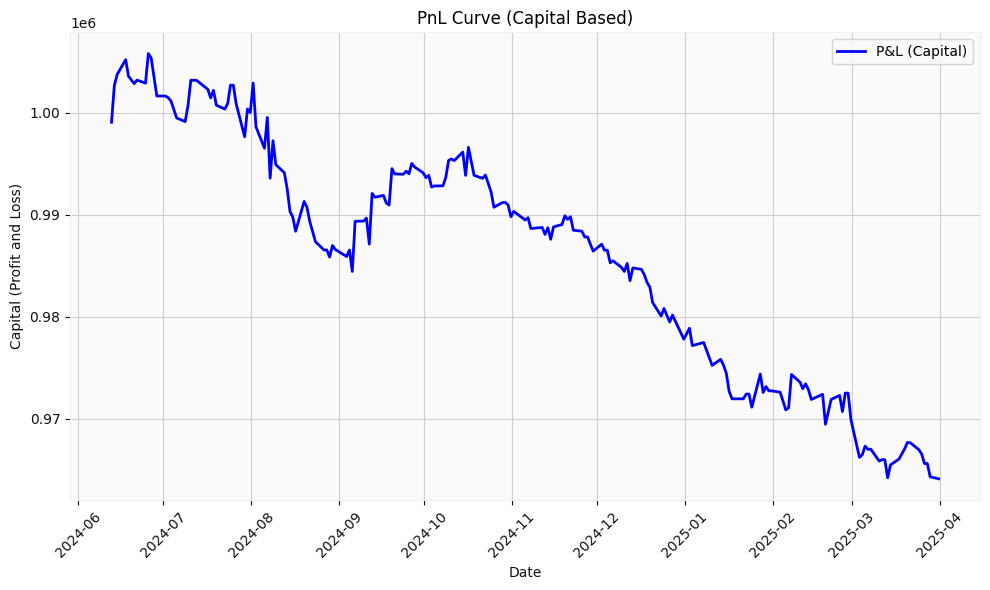

In [27]:
ba.plot_pnl()

In [45]:
idx = 0
date = daily.iloc[idx]['date']
print(idx, date)
# idx += 1
df = ba.get_historical_data(ba.contracts[0], date)
# df = df
chan = Chan()
df, df_merged = chan.process(df, log=False)
df

0 2024-05-07


,date,open,high,low,close,volume,average,barCount,pivot,bi
0,2024-05-07 09:30:00-04:00,183.48,184.01,183.40,183.84,1786200,183.634,3877,up,False
1,2024-05-07 09:31:00-04:00,183.82,183.97,183.68,183.87,358498,183.842,1669,NaN,True
2,2024-05-07 09:32:00-04:00,183.86,183.97,183.66,183.77,392099,183.808,1746,NaN,True
3,2024-05-07 09:33:00-04:00,183.77,183.91,183.62,183.78,263615,183.796,1270,NaN,True
4,2024-05-07 09:34:00-04:00,183.79,183.80,183.33,183.39,325939,183.557,1516,down,False
...,...,...,...,...,...,...,...,...,...,...
385,2024-05-07 15:55:00-04:00,182.37,182.50,182.30,182.50,200491,182.402,1175,None,False
386,2024-05-07 15:56:00-04:00,182.50,182.57,182.42,182.55,187376,182.497,995,None,False
387,2024-05-07 15:57:00-04:00,182.55,182.59,182.54,182.59,182793,182.571,962,up,False
388,2024-05-07 15:58:00-04:00,182.59,182.59,182.52,182.56,229747,182.567,1238,NaN,True
